# EE675A - Assignment 1

**Name:**  <br />
**Roll No:**
***
## Instructions

- **Release Date**: **21st Jan 2024**  
- **Deadline**: **Part B : 4th Feb 2024 11:59PM**
- Kindly name your submission files as `RollNo_Name_A1_PartB.ipynb`, based on the part you are submitting. Marks will be deducted for all submissions that do not follow the naming guidelines. <br />
- You are required to work out your answers and submit only the iPython Notebook. The code should be well commented and easy to understand as there are marks for this. This notebook can be used as a template for assignment submission. <br />
- Submissions are to be made through HelloIITK portal. Submissions made through mail will not be graded.<br />
- Answers to the theory questions if any should be included in the notebook itself. While using special symbols use the $\LaTeX$ mode <br />
- Make sure your plots are clear and have title, legends and clear lines, etc. <br />
- Plagiarism of any form will not be tolerated. If your solutions are found to match with other students or from other uncited sources, there will be heavy penalties and the incident will be reported to the disciplinary authorities. <br />
- In case you have any doubts, feel free to reach out to TAs for help. <br />

***
## Introduction

You are free to use parts of the given code but may also choose to write the whole thing on your own.  
The illustrations for Part-B are adapted from [Alejandro's blog post](https://medium.com/@alejandro.aristizabal24/understanding-reinforcement-learning-hands-on-part-2-multi-armed-bandits-526592072bdc) on Multi-Armed Bandits. Throughout the course we will be using the [Gymnasium toolkit](https://gymnasium.farama.org/index.html) for the assignements so before starting you may want to go through the [basic usage](https://gymnasium.farama.org/content/basic_usage/) and basics of gymnasium and the installation procedure.

***
# Part B: Multi-armed bandits
## Demo and Preliminaries

We will begin by getting familiar with the basic problem setup before we dig in to the actual assignement problems. Let's start by loading all the required libraries for this notebook. For generating plots you must have `ipympl` installed and `jupyter-matplotlib` extension installed and enabled.

In [163]:
# Import necessary libraries
!python.exe -m pip install --upgrade pip
!pip install "gymnasium"
!pip install ipympl
!pip install matplotlib
!pip install tqdm
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import gymnasium as gym
from tqdm import tqdm
import time

## Scenario

The Multi-Armed Bandit describes a situation in which an agent has only one state, and multiple actions to interact with the environment. Each action gives a random reward, centered on an unkown value. Our agent wants to maximize the reward received, which means it wants to find the action that yields a higher reward. Based on this, let's build the scenario.

We're going to implement the multi-armed bandit environment using OpenAI's gym interface. Also, our implementation will be vectorized for the sake of optimization. This allows us to run multiple agents on multiple environments at the same time. The code below is based on [this implementation](https://github.com/diegoalejogm/openai-k-armed-bandits)

In [164]:
from gymnasium import spaces
from gymnasium.utils import seeding
import gymnasium as gym

class ArmedBanditsEnv(gym.Env):
    """
    The famous k-Armed Bandit Environment, implemented for the gym interface.
    Initialization requires an array of length equals to k, where each item is
    a function which samples from a specified distribution.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, mean, stddev):
        assert len(mean.shape) == 2
        assert len(stddev.shape) == 2

        super(ArmedBanditsEnv, self).__init__()
        # Define action and observation space
        self.num_bandits = mean.shape[1]
        self.num_experiments = mean.shape[0]
        self.action_space = spaces.Discrete(self.num_bandits)

        # Theres one state only in the k-armed bandits problem
        self.observation_space = spaces.Discrete(1)
        self.mean = mean
        self.stddev = stddev

    def step(self, action):
        # Sample from the specified bandit using it's reward distribution
        assert (action < self.num_bandits).all()

        sampled_means = self.mean[np.arange(self.num_experiments),action]
        sampled_stddevs = self.stddev[np.arange(self.num_experiments),action]

        reward = np.random.normal(loc=sampled_means, scale=sampled_stddevs, size=(1,self.num_experiments))

        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        return observation, reward, done, info

    def reset(self):
        return 0

    def render(self, mode='human', close=False):
        pass

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]

    def close(self):
        pass


class ArmedBanditsGaussian(ArmedBanditsEnv):
    def __init__(self, num_experiments=1, num_bandits=3):
        self.means = np.random.normal(size=(num_experiments, num_bandits))

        ArmedBanditsEnv.__init__(self, self.means, np.ones((num_experiments, num_bandits)))

Here we're creating two classes, `ArmedBanditsEnv` is the main class, while `ArmedBanditsGaussian` is an auxiliary class that allows us to easily create an environment with random mean rewards for each action. Our environment receives numpy arrays for the means and standard deviations for each action. The dimensions of this arrays are described as `num_experiments`x`num_bandits`. Taking a step requires a numpy vector of size `num_experiments`, where each value specifies which action to take for each experiment. The step functions returns, among other information, a vector of reward obtained for each experiment. Let's see this in action:

In [165]:
means = np.array([[5, 1, 0, -10]]) # The mean for a four-armed bandit. Single experiment
stdev = np.array([[1, 0.1, 5, 1]]) # The standard deviation for a four-armed bandit.

env = ArmedBanditsEnv(means, stdev) # Create the environment

for i in range(4):
    action = np.array([[i]])
    _, reward, _, _ = env.step(action)
    print("Bandit:", i, " gave a reward of:", reward[0])

Bandit: 0  gave a reward of: [4.72034568]
Bandit: 1  gave a reward of: [0.9753837]
Bandit: 2  gave a reward of: [7.71013341]
Bandit: 3  gave a reward of: [-9.68665542]


## Evaluating our actions

In order to learn something from our interaction with the environment, we need to know how exactly we determine the value of our actions, as well as how to keep that value up to date. A simple strategy our agents can take is to calculate the expected return for each action. This can be done through experience by taking the average of previous rewards given by a determined action.

For example, we can use the next list of rewards to calculate the expected return of the chosen action:

$\bar{\mu}_n = \dfrac{R_1+R_2+\dots+R_n}{n}$

Having to store all the previously seen rewards to calculate the value of an action is cumbersome, inefficient and unnecessary. We can derive another form of average, called *Incremental average update rule*, which only requires us to know the previous average $\bar{\mu}_{n-1}$ and the number $n$:

$\bar{\mu}_n = \bar{\mu}_{n-1} + \dfrac{1}{n}(R_n - \bar{\mu}_{n-1})$

Here's a small demonstration of this function at work

In [166]:
def inc_avg(prev_avg, new_val, n):
    return prev_avg + 1/n*(new_val - prev_avg)

# Obtain the previous average
vals = np.array([4.5, 5.04, 5.32, 4.8, 5.11])
prev_avg = vals.mean()

# Calculate a new average using the incremental average update function
new_val = 5.18
new_avg = inc_avg(prev_avg, new_val, 6)

# Calculate the same average using all previous values for comparison
avg = np.append(vals, new_val).mean()

print("Average obtained from incremental update rule: ", new_avg)
print("Average obtained from basic average function:  ", avg)

Average obtained from incremental update rule:  4.991666666666666
Average obtained from basic average function:   4.991666666666666


This method will be used on the next strategies

## The Greedy Agent

This strategy is focused on always choosing the best known action at the time. Every time the agent takes an action, it looks at the estimated values for each action, and chooses the one that has a greater score. If more than two values look best, then the agent selects arbitrarily among those best-valued actions. This is called breaking ties arbitrarily

Taking the action with the greatest value is equivalent to using the **argmax** function. Although, we need to implement some changes so that the funciton breaks the ties the way we intend it to do:

In [167]:
def argmax(q_values):
    """
    Takes in a matrix of n*k q_values and returns the index
    of the item with the highest value for each row.
    Breaks ties randomly.
    returns: vector of size n, where each item is the index of
    the highest value in q_values for each row.
    """
    # Generate a mask of the max values for each row
    mask = q_values == q_values.max(axis=1)[:, None]
    # Generate noise to be added to the ties
    r_noise = 1e-6*np.random.random(q_values.shape)
    # Get the argmax of the noisy masked values
    return np.argmax(r_noise*mask,axis=1)

Here we're generating a mask of all the values in the input that are equal to the maximum value. Then ,we generate some noise and multiply it with the mask. Taking the argmax of this new list will be equivalent to the desired argmax with ties broken arbitrarily.

Now that we have specified the argmax function, we can declare our class for the Greedy Agent, which is capable of acting upon the environment, and updating its estimates after receiving a reward.

In [168]:
class GreedyAgent:
    def __init__(self, reward_estimates):
        """
        Our agent takes as input the initial reward estimates.
        This estimates will be updated incrementally after each
        interaction with the environment.
        """
        assert len(reward_estimates.shape) == 2

        self.num_bandits = reward_estimates.shape[1]
        self.num_experiments = reward_estimates.shape[0]
        self.reward_estimates = reward_estimates.astype(np.float64)
        self.action_count = np.zeros(reward_estimates.shape)

    def get_action(self):
        # Our agent is greedy, so there's no need for exploration.
        # Our argmax will do just fine for this situation
        action = argmax(self.reward_estimates)

        # Add a 1 to each action selected in the action count
        self.action_count[np.arange(self.num_experiments), action] += 1

        return action

    def update_estimates(self, reward, action):
        # rew is a matrix with the obtained rewards from our previuos
        # action. Use this to update our estimates incrementally
        n = self.action_count[np.arange(self.num_experiments), action]
        prev_reward_estimates = self.reward_estimates[np.arange(self.num_experiments), action]

        # Update the reward estimates incementally
        self.reward_estimates[np.arange(self.num_experiments), action] = inc_avg(prev_reward_estimates,reward,n)

The greedy agent contains a matrix for the estimates, as well as for the number of times each action has been taken. This is necessary for using the incremental average update rule, used inside the `update_estimates` function.

### Testing the agent

Let's see how the Greedy Agent behaves on the environment. For this, we're going to generate some animations where we're able to see how the agent estimates the values for each action, as well as the real values provided by the environment. Remember that the agent doesn't have access to that information.

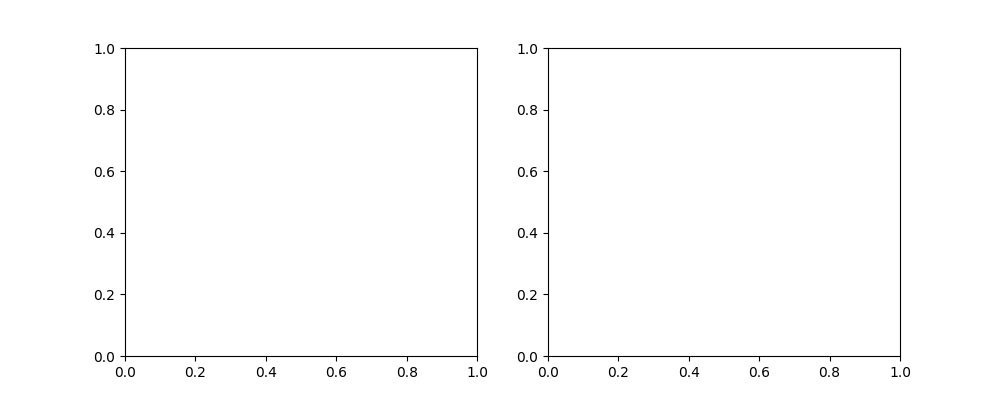

In [169]:
# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 100
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments,num_bandits)))

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    axa = [];
    for i in range(num_experiments):
        init_ax(i)
        # axa.append(init_ax(i))
    # return axa

def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)
    # return ax


# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    axa = []
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
        # axa.append(ax)
    # return axa

anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
# anim.save('./greedy-agent.gif', writer='imagemagick', fps=60)


you may try the previous block of code multiple times to see multiple animations. In general, you may realize that most of the actions are not explored by the agent, and that it will mostly stick to the one action that gave it some positive reward. The agent is good at evading negative values, but it will only land on the optimal action by pure chance.

We can plot the average behavior by doing more experiments. The next plot displays the percentage of times the agent chose the optimal action over an average of 10000 experiments.

100%|██████████| 1000/1000 [00:02<00:00, 416.05it/s]


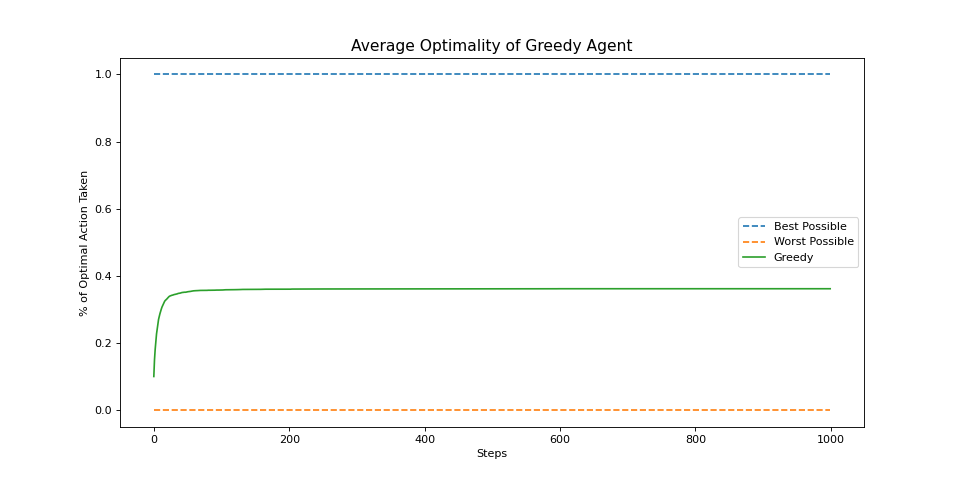

In [170]:
num_experiments = 10000
num_steps = 1000
num_actions = 10

# Initialize the environment
env = ArmedBanditsGaussian(num_experiments, num_actions)
# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments, num_actions)))

# Store the scores and averages for later plotting
averages = np.zeros((num_steps))
optimality = np.zeros((num_steps))
scores = np.zeros((num_experiments, num_steps+1))

#Store the optimal actions for later use
optimal = np.argmax(env.mean, axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)

    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(reward, action)

    # Store the average cumulative score and optimality of the current step
    scores[:,i+1] = scores[:,i] + reward
    avg_score = np.mean(scores[:,i+1]/(i+1))
    averages[i] = avg_score

    # Get optimal actions from the environment
    current_optimality = np.mean(action == optimal)
    optimality[i] = current_optimality

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(optimality)
plt.legend(["Best Possible", "Worst Possible", "Greedy"])
plt.title("Average Optimality of Greedy Agent", fontsize=14)
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()
greedy_scores = averages
greedy_optimality = optimality

The Greedy Agent chooses the best action on average ~40% of the times. Additionally, extra experience won't improve it's score, as it usually lands on a sub-optimal action on the first steps, and stays there for ever. The Greedy Agent is not a good strategy for finding the optimal action on this scenario.

## The Epsilon-Greedy Agent

Another strategy is the Epsilon Greedy Agent, which adds to the previous strategy. An Epsilon-Greedy Agent allows for some exploratory actions, by every once in a while choosing any action randomly, instead of always acting greedily. The probability of taking an exploratory action is defined by the parameter `epsilon`. An epsilon of `0` is a Greedy Agent. An epsilon of `0.2` means our agent takes a random action 20% of the time. An epsilon of `1` is an agent that behaves randomly. Let's build this new agent

In [171]:
class EpsilonGreedyAgent(GreedyAgent):
    def __init__(self, reward_estimates, epsilon):
        GreedyAgent.__init__(self, reward_estimates)
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        self.epsilon = epsilon

    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability

        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > self.epsilon).astype(int)
        # Generate both types of actions for every experiment
        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)

        self.action_count[np.arange(self.num_experiments), action] += 1

        return action

As may be seen, we're inheriting the `GreedyAgent` implementation, and only changing the `get_action` function. For taking an action, we're using a masking that defines which experiments will choose an action randomly and which will act greedily. Then, we apply that masking between random and greedy actions to obtain the action vector for all of our experiments.

### Testing the Agent

Here, we're going to use the same animation as before to observe how this new strategy behaves. Our agents will have a value of epsilon of `0.1`

c:\Users\2003s\anaconda3\envs\tsp\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


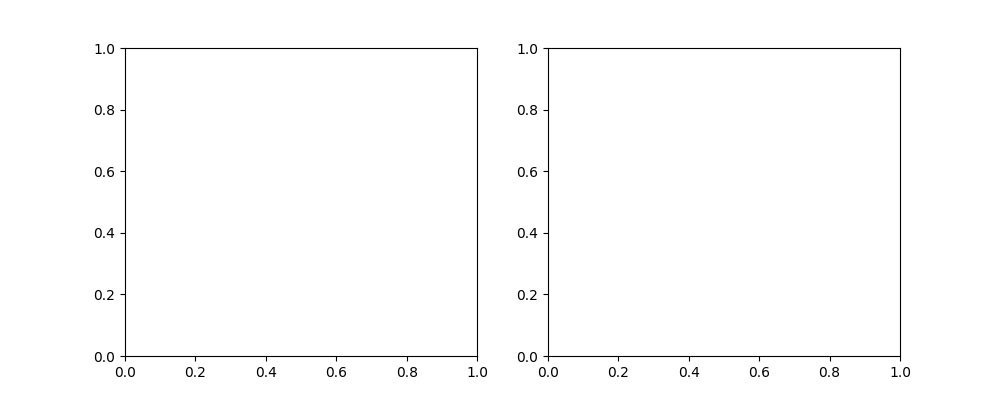

In [172]:
# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 200
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = EpsilonGreedyAgent(np.zeros((num_experiments,num_bandits)), 0.1)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)


def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()

anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=False, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
# anim.save('./epsilon-greedy-agent.gif', writer='imagemagick', fps=60)

Again, you may run the previous block multiple times to see different runs. As can be observed, the epsilon-greedy agent not only finds the optimal solution most of the times, but it is also capable of finding close estimated values for all the actions! How does our new strategy compares to the greedy agent on average?

In [173]:
def run_experiment(num_experiments=1000, num_steps=1000, num_actions=10,epsilon=0.1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon)

    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))

    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)

    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)

        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)

        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score

        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:02<00:00, 420.74it/s]


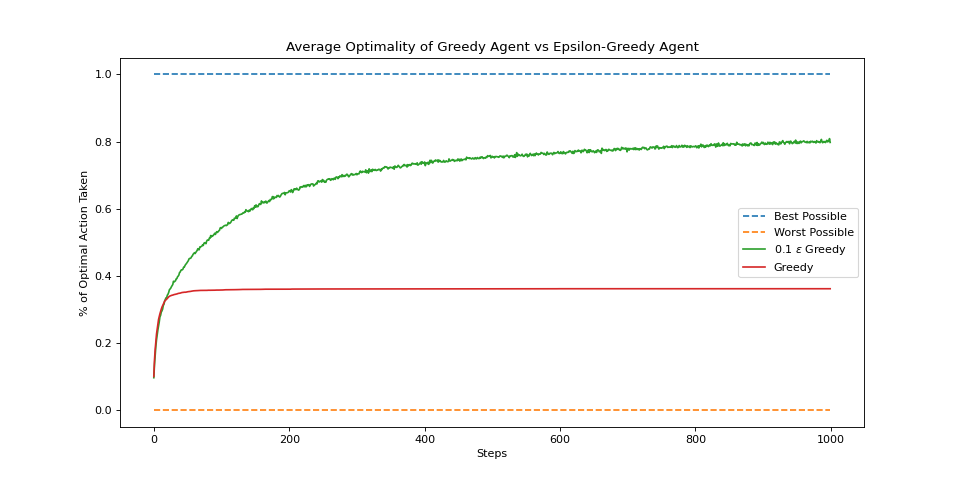

In [174]:
num_experiments = 10000
num_steps = 1000
num_actions = 10
epsilon = 0.1

balanced_eps_optimality, balanced_eps_scores = run_experiment(num_experiments, num_steps, num_actions, epsilon)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(balanced_eps_optimality)
plt.plot(greedy_optimality)
plt.legend(["Best Possible", "Worst Possible", "0.1 $\epsilon$ Greedy", "Greedy"])
plt.title("Average Optimality of Greedy Agent vs Epsilon-Greedy Agent")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

After 1000 steps, the Epsilon-Greedy Agent is capable of reaching an 80% average optimality. This means that on average, they choose the best possible action 80% of the times after that amount of iterations. We can also see how our agent is capable of improving from experience, contrary to the Greedy Agent.

## Values for epsilon

On the previous example, we used a value for `epsilon` of `0.1`. This means that the agent chose an exploratory action 10% of the times. What would have happened if we chose another action? Like with almost all hyper-parameters in Machine Learning, there's a range of values which behave better than others. Let's make an actual experiment using different values for `epsilon`

100%|██████████| 1000/1000 [00:00<00:00, 3506.84it/s]


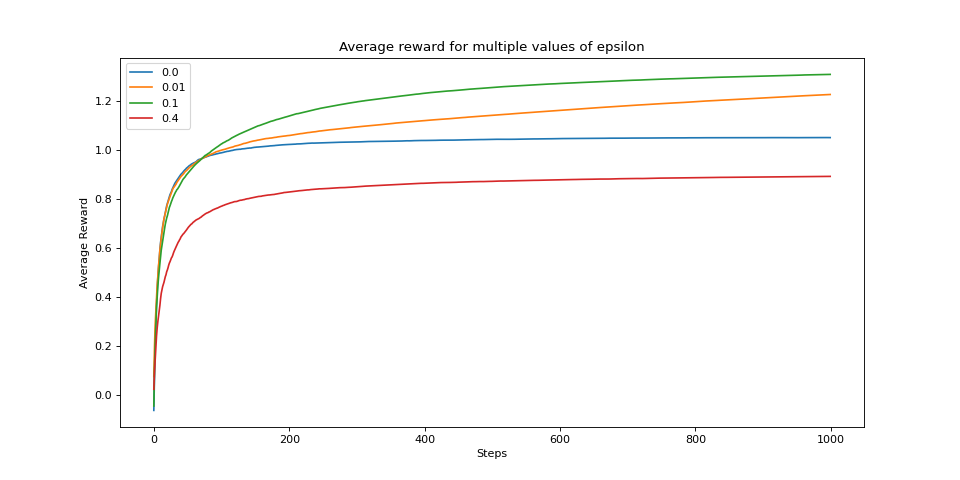

In [175]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
# plt.plot([1.6 for _ in range(num_steps)], linestyle='--') # why 1.6?


for epsilon in epsilons:
    _, reward = run_experiment(num_experiments, num_steps, num_actions, epsilon)

    plt.plot(reward)

# plt.legend(["Best Possible"] + epsilons.tolist())
plt.legend(epsilons.tolist())
plt.title("Average reward for multiple values of epsilon")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

Here, we're plotting the average amount of reward received by the agent. This is because plotting the optimality on this many tests gets too crowded and noisy. As can be seen, the agent with an epsilon of `0.1` was the one that received the most amount of reward. Values of epsilon that are too small take very few exploratory actions, and therefore take a long time to explore and find the most optimal value. On the other hand, values of `epsilon` too high will obstruct the capacity of the agent of acting optimally. Too much exploration gets in the way of exploitation.

***
## Part B questions

Now that we have familiarized ourselves with the basic setup let us test a few more stratergies as part of the assignment problem.

Consider a two-armed Bernoulli bandit scenario with true means given by $\mu_1 = \frac{1}{2}, \mu_2= \frac{1}{2}+\Delta$, for some $\Delta < \frac{1}{2}$. Let the time horizon be $T=10000$. `[20 Marks]`

### B1
Take $\Delta=\frac{1}{4}$ and run the Monte Carlo simulations to estimate the expected regret of the ETC algorithm which explores each arm $m = T^{2/3} (\log T)^{1/3}$ times before committing. Specifically, you run the ETC algorithm to compute the sample regret 
$$ \mu_2 * T - \sum_{t=1}^T R_t, $$ 
where $R_t$ is the reward obtained in time step $t$.

Repeat this experiment 500 times and estimate the expected regret by taking the average of the sample regrets you obtained in all those 500 experiments. `[5 Marks]`

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [177]:
def ETC(delta):    
    exp_reg = 0
    for i in range(1, 501):
        mu1 = 1/2
        mu2 = 1/2 + delta
        T = 10000

        m = int(T**(2/3) * (np.log(T))**(1/3))

        # Generate random values from the Bernoulli distribution
        ran_val1 = np.random.binomial(n=1, p=mu1, size=m)
        ran_val2 = np.random.binomial(n=1, p=mu2, size=m)

        regret = mu2*T
        reward = sum(ran_val1) + sum(ran_val2)

        av1 = np.mean(ran_val1)
        av2 = np.mean(ran_val2)
        rem = T-m-m

        if av1>av2:
            exploit = np.random.binomial(n=1, p=mu1, size=rem)
        else:
            exploit = np.random.binomial(1, mu2, rem)
            
        reward += sum(exploit)
        regret -= reward
        exp_reg += regret

    exp_reg /= 500
    return exp_reg

del_vals = [1/4]
ans = 0
for i in del_vals:
    ans+= ETC(i)

print(ans)

242.894


### B2

Repeat the above for various values of $\Delta \in \{0.05, 0.1, 0.2, 0.3, 0.4, 0.45\}$ and plot the estimated regret as a function of $\Delta$ and verify whether it satisfies the regret upper bound we derived in class. `[5 Marks]`

In [178]:
# write your code for the above part here

del_vals = [0.05, 0.1, 0.2, 0.3, 0.4, 0.45]
regrets_ETC = []
max_val_ETC = []
T = 10000
mv = T**(2/3) * (np.log(T))**(1/3)
print(mv)
for i in del_vals:
    regrets_ETC.append(ETC(i))
    max_val_ETC.append(mv)

print(regrets_ETC)

972.9530713186152
[48.98, 97.896, 193.572, 293.108, 387.656, 437.386]


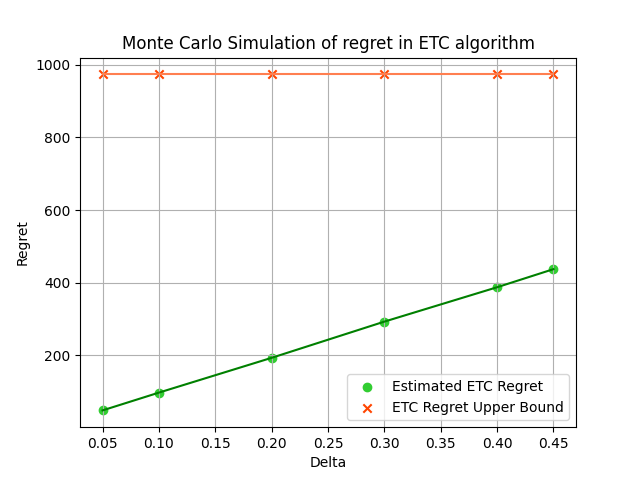

In [179]:
plt.figure()
plt.scatter(del_vals, regrets_ETC, label='Estimated ETC Regret', color='limegreen')
plt.plot(del_vals, regrets_ETC, linestyle='-', color='green')
plt.scatter(del_vals, max_val_ETC, label='ETC Regret Upper Bound', marker = 'x', color='orangered')
plt.plot(del_vals, max_val_ETC, linestyle='-', color='coral')
plt.xlabel('Delta')
plt.ylabel('Regret')
plt.title('Monte Carlo Simulation of regret in ETC algorithm')
plt.legend()
plt.grid('True')
plt.show()

### B3 
Repeat the experiment with the UCB algorithm and plot the comparison with ETC. `[10 Marks]`

In [180]:
# write your code for the above part here
def UCB(delta):
    av_reg = 0
    for tm in tqdm(range(0, 500)):
        T = 10000
        mu1 = 1/2
        mu2 = 1/2 + delta
        sam1 = np.random.binomial(1, mu1, T)
        av1 = sam1[0]
        c1 = 1
        sam2 = np.random.binomial(1, mu2, T)
        av2 = sam2[0]
        c2 = 1
        reward = av1+av2
        regret = mu2*T
        ep = np.sqrt((3*np.log(T))/(2))
        for i in range(3, T+1):
            epsilon_t1 = ep/np.sqrt(c1)
            epsilon_t2 = ep/np.sqrt(c2)
            ub1 = av1+epsilon_t1
            ub2 = av2+epsilon_t2
            if ub1>ub2:
                c1 +=1
                av1 = (av1*(c1-1)+sam1[c1-1])/c1
                reward+=sam1[c1-1]
            else:
                c2 +=1
                av2 = (av2*(c2-1)+sam2[c2-1])/c2
                reward+=sam2[c2-1]

        regret -= reward
        av_reg+=regret
    av_reg/=500
    print(av_reg)
    return av_reg

In [181]:
del_vals = [0.05, 0.1, 0.2, 0.3, 0.4, 0.45]
regrets_UCB = []
max_val_UCB = []
T = 10000
mv = np.sqrt(2*T*np.log(T))
print(mv)
for i in del_vals:
    regrets_UCB.append(UCB(i))
    max_val_UCB.append(mv)

429.19320525786947


100%|██████████| 500/500 [00:13<00:00, 36.49it/s]


85.68


100%|██████████| 500/500 [00:13<00:00, 36.55it/s]


73.312


100%|██████████| 500/500 [00:13<00:00, 35.85it/s]


49.008


100%|██████████| 500/500 [00:13<00:00, 36.73it/s]


37.4


100%|██████████| 500/500 [00:13<00:00, 36.45it/s]


26.518


100%|██████████| 500/500 [00:20<00:00, 24.40it/s]

25.576


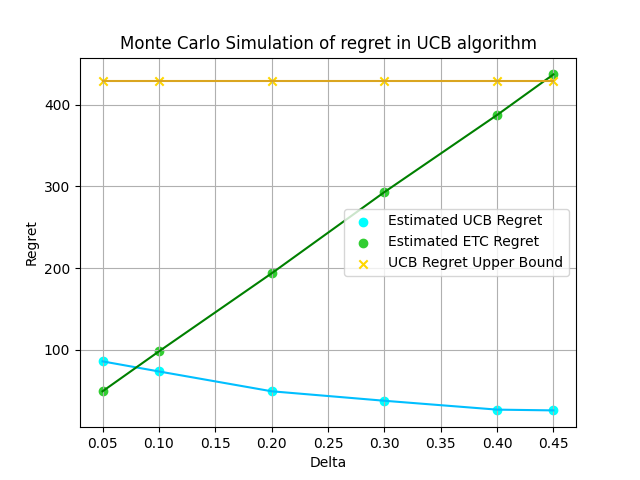

In [183]:
plt.figure()
plt.scatter(del_vals, regrets_UCB, label='Estimated UCB Regret', color='cyan')
plt.plot(del_vals, regrets_UCB, linestyle='-', color='deepskyblue')
plt.scatter(del_vals, regrets_ETC, label='Estimated ETC Regret', color='limegreen')
plt.plot(del_vals, regrets_ETC, linestyle='-', color='green')
plt.scatter(del_vals, max_val_UCB, label='UCB Regret Upper Bound', marker = 'x', color='gold')
plt.plot(del_vals, max_val_UCB, linestyle='-', color='goldenrod')
plt.xlabel('Delta')
plt.ylabel('Regret')
plt.title('Monte Carlo Simulation of regret in UCB algorithm')
plt.legend()
# plt.ylim(0, 1500)
# plt.xlim(0, 0.5)
plt.grid('True')
plt.show()

### B4
(**Bonus**) In the ETC algorithm, assume that we know $\Delta$, and choose a better $m$ as function of $\Delta$ and repeat the experiments and compare with UCB. What did you observe?

Hint: Check how many samples of exploration are required to make $\epsilon < \frac{\Delta}{2}$ with a high probability of $1-\frac{1}{T}$. `[5 Marks]`

In [184]:
# write your code for the above part here

def ETC_rev(delta):    
    exp_reg = 0
    for i in range(1, 501):
        mu1 = 1/2
        mu2 = 1/2 + delta
        T = 10000

        m = (int)((2/delta**2)*np.log(2*T)/2)

        # Generate random values from the Bernoulli distribution
        ran_val1 = np.random.binomial(n=1, p=mu1, size=m)
        ran_val2 = np.random.binomial(n=1, p=mu2, size=m)

        regret = mu2*T
        reward = sum(ran_val1) + sum(ran_val2)

        av1 = np.mean(ran_val1)
        av2 = np.mean(ran_val2)
        rem = T-m-m

        if av1>av2:
            exploit = np.random.binomial(n=1, p=mu1, size=rem)
        else:
            exploit = np.random.binomial(1, mu2, rem)

        reward += sum(exploit)
        regret -= reward
        exp_reg += regret

    exp_reg /= 500
    return exp_reg


In [185]:
del_vals = [0.05, 0.1, 0.2, 0.3, 0.4, 0.45]
regrets = []
UCB_regret = []

for i in del_vals:
    regrets.append(ETC_rev(i))
    # UCB_regret.append(UCB(i))
print(regrets)

[196.078, 97.646, 45.688, 30.536, 26.076, 21.468]


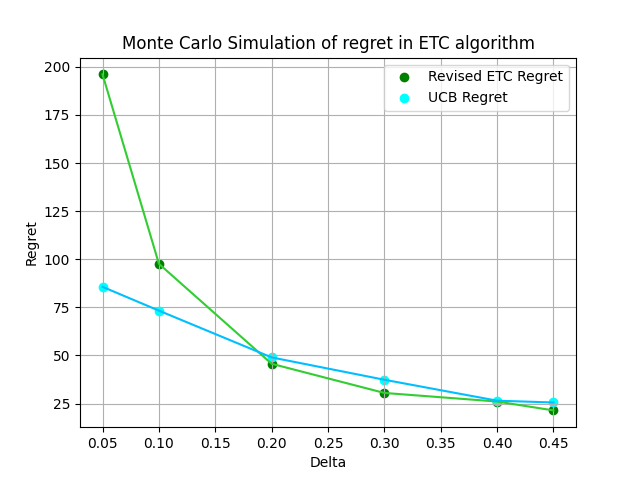

In [186]:
plt.clf
plt.figure()
plt.scatter(del_vals, regrets, label='Revised ETC Regret', color='green')
plt.plot(del_vals, regrets, linestyle='-', color='limegreen')
plt.scatter(del_vals, regrets_UCB, label='UCB Regret', color='cyan')
plt.plot(del_vals, regrets_UCB, linestyle='-', color='deepskyblue')
# plt.scatter(del_vals, UCB_regret, label='UCB Regret', color='cyan')
# plt.plot(del_vals, UCB_regret, linestyle='-', color='deepskyblue')
plt.xlabel('Delta')
plt.ylabel('Regret')
plt.title('Monte Carlo Simulation of regret in ETC algorithm')
plt.legend()
plt.grid('True')
plt.show()